## Librerías

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as kr
import keras
import matplotlib.pyplot as plt
import joblib
import warnings

# Modelos
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import BernoulliNB
from keras.models import Sequential
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    RepeatedKFold,
    GridSearchCV,
    RandomizedSearchCV
)

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score,
    log_loss
)

from keras.layers import Dropout
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from keras.models import load_model
from tqdm import tqdm
warnings.filterwarnings('ignore')

## Funciones

In [2]:
labels_4_intensidades = [1.0, 2.0, 3.0, 4.0] # Etiquetas para la matriz de confusion para 4 intensidades
labels_3_intensidades = [1.0, 2.0, 3.0]      # Etiquetas para la matriz de confusion para 3 intensidades

def get_X_y(df):
    FEATURES = ['A_t','B_t','C_t','D_t','E_t','Valor_1','Valor_2','Valor_3',
               'Valor_4','Valor_5','Valor_6','Valor_7','Valor_8','Valor_9','Valor_10']
    TARGET = 'label'

    X = df[FEATURES]
    y = df[TARGET]

    return X, y

## Preparación del dataset

In [3]:
df_prueba = pd.read_csv("Ruta_Dataset/tu_archivo.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'Ruta_Dataset/tu_archivo.csv'

In [5]:
#df_prueba = pd.read_csv("dataset_completo_caracteristicas_ampliadas_todas_combinaciones_v1_textoProcesado.csv", delimiter=';')
df_prueba = pd.read_csv("/content/drive/MyDrive/HATEMEDIA/Intensidades/dataset_completo_caracteristicas_ampliadas_todas_combinaciones_v1_textoProcesado.csv", delimiter=';')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_prueba.columns

Index(['A', 'B', 'C', 'D', 'E', 'comentario', 'label', 'A_t', 'B_t', 'C_t',
       'D_t', 'E_t', 'Valor_1', 'Valor_2', 'Valor_3', 'Valor_4', 'Valor_5',
       'Valor_6', 'Valor_7', 'Valor_8', 'Valor_9', 'Valor_10'],
      dtype='object')

In [ ]:
df_prueba['label'].value_counts()

label
0.0    563208
4.0     10920
1.0      1531
5.0       219
3.0       176
2.0       156
6.0        13
Name: count, dtype: int64

In [ ]:
df_prueba = df_prueba[df_prueba['label'] != 0.0] # Eliminamos las entradas de no odio

# Fusionar en 4 intensidades
df_prueba['label'] = df_prueba['label'].apply(lambda x: 1 if x==1 else (x))
df_prueba['label'] = df_prueba['label'].apply(lambda x: 1 if x==2 else (x))
df_prueba['label'] = df_prueba['label'].apply(lambda x: 2 if x==3 else (x))
df_prueba['label'] = df_prueba['label'].apply(lambda x: 3 if x==4 else (x))
df_prueba['label'] = df_prueba['label'].apply(lambda x: 4 if x==5 else (x))
df_prueba['label'] = df_prueba['label'].apply(lambda x: 4 if x==6 else (x))

labels = labels_4_intensidades

In [ ]:
df_prueba = df_prueba[df_prueba['label'] != 0.0] # Eliminamos las entradas de no odio

# Fusionar en 3 intensidades
df_prueba['label'] = df_prueba['label'].apply(lambda x: 1 if x==1 else (x))
df_prueba['label'] = df_prueba['label'].apply(lambda x: 1 if x==2 else (x))
df_prueba['label'] = df_prueba['label'].apply(lambda x: 2 if x==3 else (x))
df_prueba['label'] = df_prueba['label'].apply(lambda x: 2 if x==4 else (x))
df_prueba['label'] = df_prueba['label'].apply(lambda x: 3 if x==5 else (x))
df_prueba['label'] = df_prueba['label'].apply(lambda x: 3 if x==6 else (x))

labels = labels_3_intensidades

In [ ]:
df_prueba['label'].value_counts()
df_prueba = df_prueba.dropna(subset='label')

In [ ]:
int1 = df_prueba[df_prueba['label'] == 1.0]
int2 = df_prueba[df_prueba['label'] == 2.0]
int3 = df_prueba[df_prueba['label'] == 3.0]
int4 = df_prueba[df_prueba['label'] == 4.0]
df_prueba = pd.concat([int1.head(20), int2.head(20), int3.head(20), int4.head(20)])

X, y = get_X_y(df_prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)

In [ ]:
df_prueba.to_csv("dataset_prueba.csv", index=False)

## GRADIENT BOOSTING

In [ ]:
param_grid = {'n_estimators': [50, 1000],
              'max_features': ['auto','sqrt', 'log2'],
              'max_depth': [None, 1, 3, 5, 10],
              'subsample': [0.5, 1],
              'learning_rate': [0.01, 0.1]
              }

gradient_grid = GridSearchCV(
    estimator=GradientBoostingClassifier(),
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=None,
    cv=RepeatedKFold(n_splits=5, n_repeats=1, random_state=123),
    refit=True,
    verbose=2,
    return_train_score=True
)

gradient_grid.fit(X_train, y_train)

predict_gradient_CV = gradient_grid.predict(X_test)
gradient_CV_accuracy = accuracy_score(y_test, predict_gradient_CV)

best_params_grid_gradient = gradient_grid.best_params_

gb_classifier = GradientBoostingClassifier(
    n_estimators=best_params_grid_gradient['n_estimators'],
    max_depth=best_params_grid_gradient['max_depth'],
    max_features=best_params_grid_gradient['max_features'],
    subsample=best_params_grid_gradient['subsample'],
    learning_rate=best_params_grid_gradient['learning_rate']
)

print("Empieza el entrenamiento")
gb_classifier.fit(X=X_train, y=y_train)

predicted_gb_classifier_train = gb_classifier.predict(X_train)
predicted_gb_classifier = gb_classifier.predict(X_test)

accuracy_gb_classifier_train = accuracy_score(y_true=y_train,y_pred=predicted_gb_classifier_train,)
accuracy_gb_classifier = accuracy_score(y_true=y_test,y_pred=predicted_gb_classifier,)


precision = classification_report(y_test, predicted_gb_classifier)

probs_train = gb_classifier.predict_proba(X_train)
probs_test = gb_classifier.predict_proba(X_test)
logloss_train = log_loss(y_train, probs_train)
logloss_test = log_loss(y_test, probs_test)

print('----- GRADIENT BOOSTING -----')
print('Accuracy train:',accuracy_gb_classifier_train)
print('Accuracy test:',accuracy_gb_classifier)
print('Pérdida logarítmica en entrenamiento:', logloss_train)
print('Pérdida logarítmica en prueba:', logloss_test)

report_gb = classification_report(y_test, predicted_gb_classifier)
print('Reporte de clasificación:\n', report_gb)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] END learning_rate=0.01, max_depth=None, max_features=auto, n_estimators=50, subsample=0.5; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=None, max_features=auto, n_estimators=50, subsample=0.5; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=None, max_features=auto, n_estimators=50, subsample=0.5; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=None, max_features=auto, n_estimators=50, subsample=0.5; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=None, max_features=auto, n_estimators=50, subsample=0.5; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=None, max_features=auto, n_estimators=50, subsample=1; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=None, max_features=auto, n_estimators=50, subsample=1; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=None, max_features=auto, n_estimators=50, subsample=1; total time=   0.1s
[CV] END learning_rate=

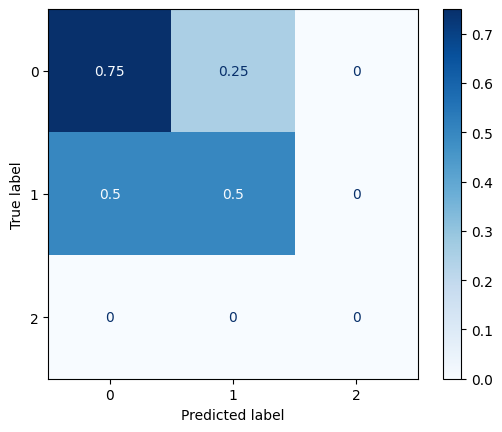

['modelo_GB_intensidades.joblib']

In [ ]:
gb_confusion_matrix = confusion_matrix(y_true=y_test, y_pred=predicted_gb_classifier, normalize = 'true', labels=labels)

confusionMatrixDisplay = ConfusionMatrixDisplay(
    confusion_matrix=gb_confusion_matrix
)

confusionMatrixDisplay.plot(cmap='Blues')
plt.show()

joblib.dump(gb_classifier, 'modelo_GB_intensidades.joblib')

## RANDOM FOREST

In [ ]:
param_grid_rf = {
    'n_estimators': [100, 200, 300, 400],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2,4,5,6],
    'criterion' :['gini', 'entropy']
}

rf =RandomForestClassifier()

forest_grid = GridSearchCV(estimator = rf, param_grid=param_grid_rf, cv= 5)
forest_grid.fit(X_train, y_train)
best_params_RF = forest_grid.best_params_
best_model_RF = forest_grid.best_estimator_
print(f'Mejores parámetros: {best_params_RF}')
predictions = best_model_RF.predict(X_test)


rf_acc = accuracy_score(predictions, y_test)
print('Accuracy',rf_acc)

report = classification_report(y_test, predictions)
print('Reporte de clasificación:\n', report)

Mejores parámetros: {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 100}
Accuracy 0.375
Reporte de clasificación:
               precision    recall  f1-score   support

         1.0       0.40      0.50      0.44         4
         2.0       0.33      0.25      0.29         4

    accuracy                           0.38         8
   macro avg       0.37      0.38      0.37         8
weighted avg       0.37      0.38      0.37         8



In [ ]:
RandomForest = confusion_matrix(y_true = y_test, y_pred = predictions, normalize='true', labels = labels)

confusionMatrixDisplay = ConfusionMatrixDisplay(
    confusion_matrix = RandomForest
)

confusionMatrixDisplay.plot(cmap='Blues')
plt.show()

# joblib.dump(forest_grid, 'modelo_RF_intensidades.joblib')

NameError: name 'confusion_matrix' is not defined

## NAIVE BAYES

In [ ]:
gnb = BernoulliNB(
            alpha=1.0,
            binarize=0.0,
            fit_prior=True,
            class_prior=None,
        )

gnb.fit(X_train, y_train)
pred_nb = gnb.predict(X_test)
gnb_acc = accuracy_score(pred_nb, y_test)
print('Accuracy: ',gnb_acc)

report_nb = classification_report(y_test, pred_nb)
print('Reporte de clasificación:\n', report_nb)

Accuracy:  0.3125
Reporte de clasificación:
               precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         4
         2.0       0.50      0.25      0.33         4
         3.0       0.43      0.75      0.55         4
         4.0       0.14      0.25      0.18         4

    accuracy                           0.31        16
   macro avg       0.27      0.31      0.27        16
weighted avg       0.27      0.31      0.27        16



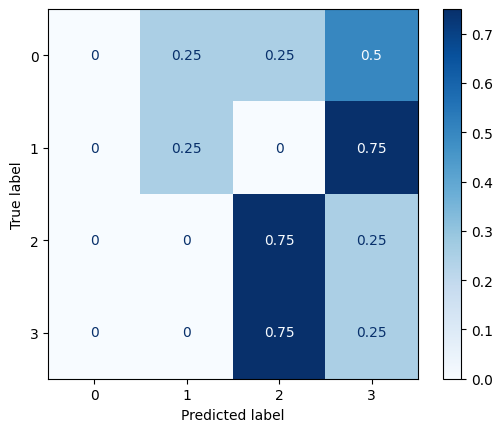

In [ ]:
NaiveBayes = confusion_matrix(y_true = y_test, y_pred = pred_nb, normalize='true', labels = labels)

confusionMatrixDisplay = ConfusionMatrixDisplay(
    confusion_matrix = NaiveBayes
)

confusionMatrixDisplay.plot(cmap='Blues')
plt.show()

# joblib.dump(gnb, 'modelo_NaiveBayes_intensidades.joblib')

## MLP

In [ ]:
# Mapeos las etiquetas para que esten entre 0 y 3 para 4 intensidades
mapping = {1: 0, 2: 1, 3: 2, 4: 3}
y_train = y_train.replace(mapping)
y_test = y_test.replace(mapping)

labels = [mapping[label] for label in labels]

In [ ]:
opt_adam = Adam(
    learning_rate=0.01,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
  )

# Crear modelo
model_mlp = Sequential()
model_mlp.add(Dense(64, input_dim=15, activation='relu')) # Capa de entrada
model_mlp.add(Dense(32, activation='relu'))
model_mlp.add(Dense(len(y.value_counts()), activation='softmax')) # Capa de salida

# Compilar modelo
model_mlp.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt_adam,
    metrics=['accuracy']
)

# Callback para parada temprana
early_stop = EarlyStopping(monitor='loss', patience=100, restore_best_weights=True)

# Entrenar modelo
history = model_mlp.fit(
    X_train,
    y_train,
    epochs=10,
    validation_data=(X_test, y_test),
    verbose=1, #para imprimir mensajes del progreso (0, 1)
    callbacks=[early_stop]
)

predicted_mlp = model_mlp.predict(X_test)
predicted_labels = np.argmax(predicted_mlp, axis=1)

# Evaluar modelo
print('===== Train =====')
result_train = model_mlp.evaluate(X_train, y_train)
print('===== Test =====')
result_test = model_mlp.evaluate(X_test, y_test)

# Reporte clasificación
report_mlp = classification_report(y_test, predicted_labels)
print('Reporte de clasificación:\n', report_mlp)

Epoch 1/10
2/2 [==============================] - 0s 114ms/step - loss: 1.4102 - accuracy: 0.2344 - val_loss: 1.4086 - val_accuracy: 0.2500
Epoch 2/10
2/2 [==============================] - 0s 21ms/step - loss: 1.2909 - accuracy: 0.2969 - val_loss: 1.4407 - val_accuracy: 0.2500
Epoch 3/10
2/2 [==============================] - 0s 24ms/step - loss: 1.2593 - accuracy: 0.3438 - val_loss: 1.4668 - val_accuracy: 0.3125
Epoch 4/10
2/2 [==============================] - 0s 25ms/step - loss: 1.2324 - accuracy: 0.3750 - val_loss: 1.4985 - val_accuracy: 0.3125
Epoch 5/10
2/2 [==============================] - 0s 20ms/step - loss: 1.2086 - accuracy: 0.4375 - val_loss: 1.5332 - val_accuracy: 0.2500
Epoch 6/10
2/2 [==============================] - 0s 22ms/step - loss: 1.1905 - accuracy: 0.5000 - val_loss: 1.5594 - val_accuracy: 0.3125
Epoch 7/10
2/2 [==============================] - 0s 23ms/step - loss: 1.1691 - accuracy: 0.5000 - val_loss: 1.6007 - val_accuracy: 0.3125
Epoch 8/10
2/2 [==========

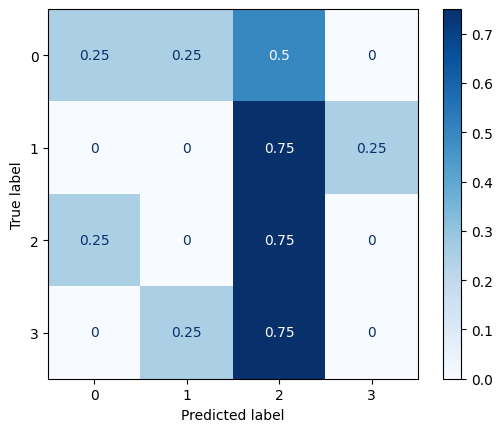

['modelo_MLP_intensidades.joblib']

In [ ]:
MLP_matrix = confusion_matrix(y_true = y_test, y_pred = predicted_labels, normalize='true', labels = labels)

confusionMatrixDisplay = ConfusionMatrixDisplay(
confusion_matrix = MLP_matrix
)

confusionMatrixDisplay.plot(cmap='Blues')
plt.show()

joblib.dump(model_mlp, 'modelo_MLP_intensidades.joblib')

## CART

In [ ]:
dt = DecisionTreeClassifier()
params_dt = {
    'max_depth': [None, 1,2,3,4,5,6,10,20],
    'min_samples_leaf': [1,2,3,4,5,6,10,20],
    'min_samples_split': [1,2,3,4,5,6,10,20],
    'max_features': [None, 'auto','sqrt', 'log2'],
    'ccp_alpha': [None, 0.001, 0.005, 0.01]
}

grid_dt = GridSearchCV(estimator=dt,
                       param_grid=params_dt,
                       scoring='accuracy',
                       #verbose=2,
                       cv=RepeatedKFold(n_splits=5, n_repeats=10, random_state=123),
                       n_jobs=-1)

grid_dt.fit(X_train, y_train)

best_params_grid_dt = grid_dt.best_params_

predict_dt_CV = grid_dt.predict(X_test)
dt_CV_accuracy = accuracy_score(y_test, predict_dt_CV)

print('Mejores parámetros CART',best_params_grid_dt)
print('Accuracy CART:', dt_CV_accuracy)

cart = DecisionTreeClassifier(max_depth=best_params_grid_dt['max_depth'],
                              max_features=best_params_grid_dt['max_features'],
                              min_samples_split=best_params_grid_dt['min_samples_split'],
                              ccp_alpha = best_params_grid_dt['ccp_alpha'],
                              min_samples_leaf=best_params_grid_dt['min_samples_leaf'])

cart.fit(X=X_train, y=y_train)
cart_pred_train = cart.predict(X_train)
cart_pred = cart.predict(X_test)

cart_acc_train = accuracy_score(y_train, cart_pred_train)
accuracy = accuracy_score(y_test, cart_pred)

CartClassifier = confusion_matrix(y_true=y_test, y_pred=cart_pred, normalize = 'true', labels=labels)

print("----- CART -----")
print("Accuracy en entrenamiento:", cart_acc_train)
print("Accuracy en prueba:", accuracy)

report_cart = classification_report(y_test, cart_pred)
print('Reporte de clasificación:\n', report_cart)

Mejores parámetros CART {'ccp_alpha': 0.01, 'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 3}
Accuracy CART: 0.0625
----- CART -----
Accuracy en entrenamiento: 0.53125
Accuracy en prueba: 0.25
Reporte de clasificación:
               precision    recall  f1-score   support

         0.0       0.50      0.50      0.50         4
         1.0       0.00      0.00      0.00         4
         2.0       0.67      0.50      0.57         4
         3.0       0.00      0.00      0.00         4

    accuracy                           0.25        16
   macro avg       0.29      0.25      0.27        16
weighted avg       0.29      0.25      0.27        16



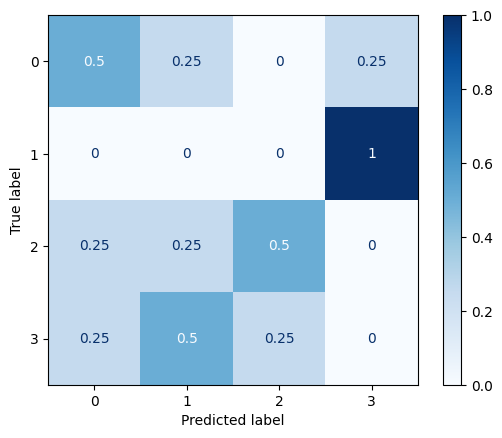

In [ ]:
CartClassifier = confusion_matrix(y_true=y_test, y_pred=cart_pred, normalize = 'true', labels=labels)

confusionMatrixDisplay = ConfusionMatrixDisplay(
        confusion_matrix=CartClassifier
    )

confusionMatrixDisplay.plot(cmap='Blues')
plt.show()

# joblib.dump(cart, 'modelo_CART_intensidades.joblib')

## SVM

In [ ]:
param_grid_svm = {
        "C": [1e3, 1e5],
        "gamma":[1e-4, 1e-1],
    }

svm_grid = RandomizedSearchCV(SVC(kernel="rbf", class_weight="balanced"),
                              param_grid_svm,
                              n_iter=20)
svm_grid.fit(X_train, y_train)
predict_svm_grid = svm_grid.predict(X_test)
predict_svm_grid_train = svm_grid.predict(X_train)
acc_svm = accuracy_score(y_test, predict_svm_grid)
acc_svm_train = accuracy_score(y_train, predict_svm_grid_train)

print('----- SVM -----')
print('Accuracy train:',acc_svm_train)
print('Accuracy test:',acc_svm)

report_svm = classification_report(y_test, predict_svm_grid)
print('Reporte de clasificación:\n', report_svm)

----- SVM -----
Accuracy train: 0.453125
Accuracy test: 0.1875
Reporte de clasificación:
               precision    recall  f1-score   support

         0.0       0.33      0.25      0.29         4
         1.0       0.22      0.50      0.31         4
         2.0       0.00      0.00      0.00         4
         3.0       0.00      0.00      0.00         4

    accuracy                           0.19        16
   macro avg       0.14      0.19      0.15        16
weighted avg       0.14      0.19      0.15        16



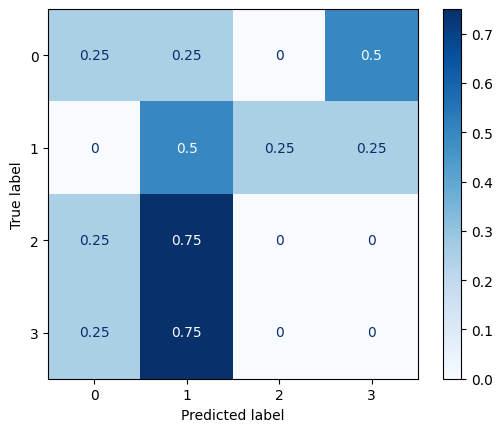

In [ ]:
SVM_matrix = confusion_matrix(y_true = y_test,
                                  y_pred = predict_svm_grid,
                                  normalize='true',
                                  labels = labels)

confusionMatrixDisplay = ConfusionMatrixDisplay(
    confusion_matrix = SVM_matrix
)

confusionMatrixDisplay.plot(cmap='Blues')
plt.show()

# joblib.dump(svm_grid, 'modelo_SVM_intensidades.joblib')